# Demonstration on a toy problem

In [1]:
import numpy as np
import hypothesis
import torch
import os
import matplotlib.pyplot as plt
import warnings

from hypothesis.visualization.util import make_square
from toy import allocate_prior
from toy import load_estimator
from toy import Simulator
from toy import RatioEstimator
from toy import JointTrain
from toy import JointTest

## Setting and setup

In [2]:
prior = allocate_prior()
simulator = Simulator() # The likelihood model is normal

In [3]:
# Draw a sample from the joint.
truth = prior.sample()
x_o = simulator(truth) # Draw x_o ~ N(truth, 1)

In [4]:
# Cleanup the old data files if they are present
!rm -r estimators

## Training

We train the ratio estimator using the binary provided by the [`hypothesis`](https://github.com/montefiore-ai/hypothesis) package.

In [5]:
!python -u -m hypothesis.bin.ratio_estimation.train -h

usage: Amortised Approximate Ratio Estimator training [-h] [--data-parallel]
                                                      [--disable-gpu]
                                                      [--out OUT] [--show]
                                                      [--dont-shuffle]
                                                      [--denominator DENOMINATOR]
                                                      [--amsgrad]
                                                      [--batch-size BATCH_SIZE]
                                                      [--conservativeness CONSERVATIVENESS]
                                                      [--epochs EPOCHS]
                                                      [--logits] [--lr LR]
                                                      [--lrsched]
                                                      [--lrsched-every LRSCHED_EVERY]
                                                      [--lrsched-gamma LRSCHED_GAMMA]
  

### Hyperparameters

In [6]:
batch_size = 4096

In [7]:
epochs = 10

In [8]:
learning_rate = 0.0001

In [9]:
weight_decay = 0.0

In [10]:
num_estimators = 3

### Training procedure

```console
python -u -m hypothesis.bin.ratio_estimation.train
           --data-paralle                           # Automatically train the model on multiple GPU's when the resources are available
           --out $path                              # Store the trained models and other metadata in the specified folder
           --show                                   # Show the progress of the training procedure in `stdout`
           --denominator "inputs|outputs"           # Denominator of the training criterion '|' denotes an independence relation. 
                                                    #   -> p(inputs)p(outputs) -> so the ratio it will learn is p(inputs,outputs)/(p(inputs)p(outputs)) 
                                                    #   -> pointwise mutual information
           --batch-size $batch_size                 # Batch size
           --conservativeness 0.0                   # Conservativeness criterion, how much weight should be given to the prior. 
                                                    #  -> Convenient way to impose a conservative estimation. 
                                                    #  -> Setting this value to 1 will result in a posterior that is indistinghuisable from the prior.
           --epochs $epochs                         # Number of epochs
           --lr $learning_rate                      # Learning rate
           --lrsched                                # Enables learning rate scheduling
           --lrsched-every 5                        # Schedule every 5 epochs
           --lrsched-gamma 0.5                      # Decay learning rate every 5 epochs by 0.5
           --weight-decay $weight_decay             # Weight decay, automatically enables the AdamW optimizer.
           --workers 8                              # Number of concurrent data loaders
           --data-train "toy.JointTrain"            # Class of the training dataset
           --data-test "toy.JointTest"              # Class of the test dataset
           --estimator "toy.RatioEstimator"         # Class of the ratio estimator, should accept the keywords defined in `--denominator`.
                                                    #  -> forward(inputs=inputs, outputs=outputs).
```

In [11]:
!mkdir -p estimators

for index in range(num_estimators):
    path = "estimators/" + str(index).zfill(5)
    # Check if the model has been trained
    if not os.path.exists(path + "/best-model.th"):
        print("\nTraining started!")
        !python -u -m hypothesis.bin.ratio_estimation.train \
           --data-parallel \
           --out $path \
           --show \
           --denominator "inputs|outputs" \
           --batch-size $batch_size \
           --conservativeness 0.0 \
           --epochs $epochs \
           --lr $learning_rate \
           --lrsched \
           --lrsched-every 5 \
           --lrsched-gamma 0.5 \
           --weight-decay $weight_decay \
           --workers 8 \
           --data-train "toy.JointTrain" \
           --data-test "toy.JointTest" \
           --estimator "toy.RatioEstimator"


Training started!
Test loss 0.32771736517792843: 100%|████████████| 10/10 [03:26<00:00, 20.64s/it]
Total epochs:		10
Best training loss:	0.2915310263633728
Final training loss:	0.32228296995162964
Best testing loss:	0.3260836374075686
Best test epoch:	9
Final test loss:	0.32771736517792843

Training started!
Test loss 0.3265163843504718: 100%|█████████████| 10/10 [03:28<00:00, 20.84s/it]
Total epochs:		10
Best training loss:	0.2991333603858948
Final training loss:	0.32102590799331665
Best testing loss:	0.3265163843504718
Best test epoch:	10
Final test loss:	0.3265163843504718

Training started!
Test loss 0.3278562894365827: 100%|█████████████| 10/10 [03:30<00:00, 21.02s/it]
Total epochs:		10
Best training loss:	0.2885107398033142
Final training loss:	0.3093600571155548
Best testing loss:	0.32710059414632986
Best test epoch:	8
Final test loss:	0.3278562894365827


The loss curves:

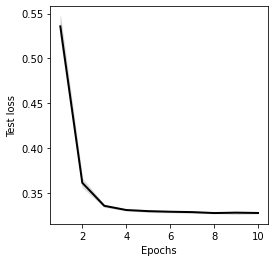

In [29]:
import glob

paths = "estimators/*/losses-test.npy"
losses = np.vstack([np.load(p).reshape(1, -1) for p in glob.glob(paths)])

epochs = np.arange(1, len(losses[0]) + 1)
m = np.mean(losses, axis=0)
s = np.std(losses, axis=0)
plt.plot(epochs, m, color="black", lw=2)
plt.fill_between(epochs, m - s, m + s, color="black", alpha=.1)
plt.ylabel("Test loss")
plt.xlabel("Epochs")
make_square(plt.gca())
plt.show()

## Inference

In [12]:
# Load the trained ratio estimator, and prepare the inputs.
resolution = 100
r = load_estimator("estimators/*/best-model.th")
inputs = torch.linspace(prior.low, prior.high, resolution).view(-1, 1)
outputs = x_o.repeat(resolution).view(-1, 1)

We now have all components to compute

$$
\log\hat{p}(\vartheta\vert x) = \log p(\vartheta) + \log\hat{r}(x\vert\vartheta)
$$

In [13]:
# Compute the posterior
log_posterior = prior.log_prob(inputs) + r.log_ratio(inputs=inputs, outputs=outputs)

As you can tell, we compute the posterior density function by evaluating the input space for the observable $x_o$.

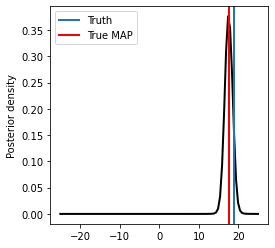

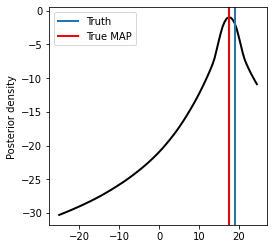

In [14]:
# Plot the posterior
plt.plot(inputs.detach().numpy(), log_posterior.exp().detach().numpy(), lw=2, color="black")
plt.axvline(truth, lw=2, color="C0", label="Truth")
plt.axvline(x_o, lw=2, color="red", label="True MAP")
plt.ylabel("Posterior density")
make_square(plt.gca())
plt.legend()
plt.show()

# Plot the posterior
plt.plot(inputs.detach().numpy(), log_posterior.detach().numpy(), lw=2, color="black")
plt.axvline(truth, lw=2, color="C0", label="Truth")
plt.axvline(x_o, lw=2, color="red", label="True MAP")
plt.ylabel("Posterior density")
make_square(plt.gca())
plt.legend()
plt.show()

Due to the amortization, we can simply evaluate the posterior for a different observable without retraining! This enables fast likelihood-free inference when confronted with many observables.

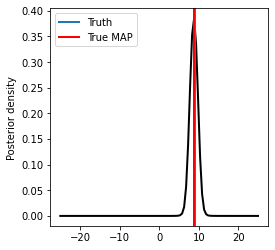

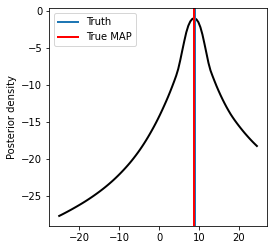

In [15]:
# Draw a sample from the joint.
truth = prior.sample()
x_o = simulator(truth)

# Prepare the inputs for the ratio estimator
inputs = torch.linspace(prior.low, prior.high, resolution).view(-1, 1)
outputs = x_o.repeat(resolution).view(-1, 1)

# Compute the posterior
log_posterior = prior.log_prob(inputs) + r.log_ratio(inputs=inputs, outputs=outputs)

# Plot the posterior
plt.plot(inputs.detach().numpy(), log_posterior.exp().detach().numpy(), lw=2, color="black")
plt.axvline(truth, lw=2, color="C0", label="Truth")
plt.axvline(x_o, lw=2, color="red", label="True MAP")
plt.ylabel("Posterior density")
make_square(plt.gca())
plt.legend()
plt.show()

# Plot the log posterior
plt.plot(inputs.detach().numpy(), log_posterior.detach().numpy(), lw=2, color="black")
plt.axvline(truth, lw=2, color="C0", label="Truth")
plt.axvline(x_o, lw=2, color="red", label="True MAP")
plt.ylabel("Posterior density")
make_square(plt.gca())
plt.legend()
plt.show()